# Uyarılar
 Öncelikle daha temiz bir çıktı alabilmek için kodun işleyişini bozmayan uyarıları gizliyorum.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


## 1. Kütüphanelerin ve Parametrelerin Tanımlanması
Projede kullanacağımız temel kütüphaneleri ve bazı ana parametreleri tanımlıyoruz.

In [2]:
import os
import random
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

img_height, img_width = 150, 150
batch_size = 32
epochs = 20


E0000 00:00:1758827511.743852      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758827511.795994      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Derin Öğrenme Modeli İçin Callback'lerin Tanımlanması

Olası hatalara karşın EarlyStopping ve ReduceLROnPlateau callback'leri ile eğitim performansını optimize ediyoruz.


In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)


## 3. Veri Setinin Yüklenmesi ve Sınıfların Görüntülenmesi

Çiçek görsellerinin bulunduğu dizinden sınıf isimlerini okuyoruz ve örnek sınıfları ekrana yazdırıyoruz.


In [4]:
data_dir = '/kaggle/input/flowers-recognition/flowers'
classes = os.listdir(data_dir)
print("Sınıf sayısı:", len(classes))
print("Sınıflar örnekleri:", classes[:5])


Sınıf sayısı: 5
Sınıflar örnekleri: ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']


## 4. Sınıflardan Rastgele 9 Görselin Görselleştirilmesi

Her bir görselin ait olduğu çiçek türünü başlık olarak ekleyerek, rastgele örnekler çizdiriyoruz.


## 5. Veri Augmentasyonu ve Ön İşleme

Görseller üzerinde çeşitli dönüşümler ile data augmentasyonu yapılıyor. (%20 validation split).


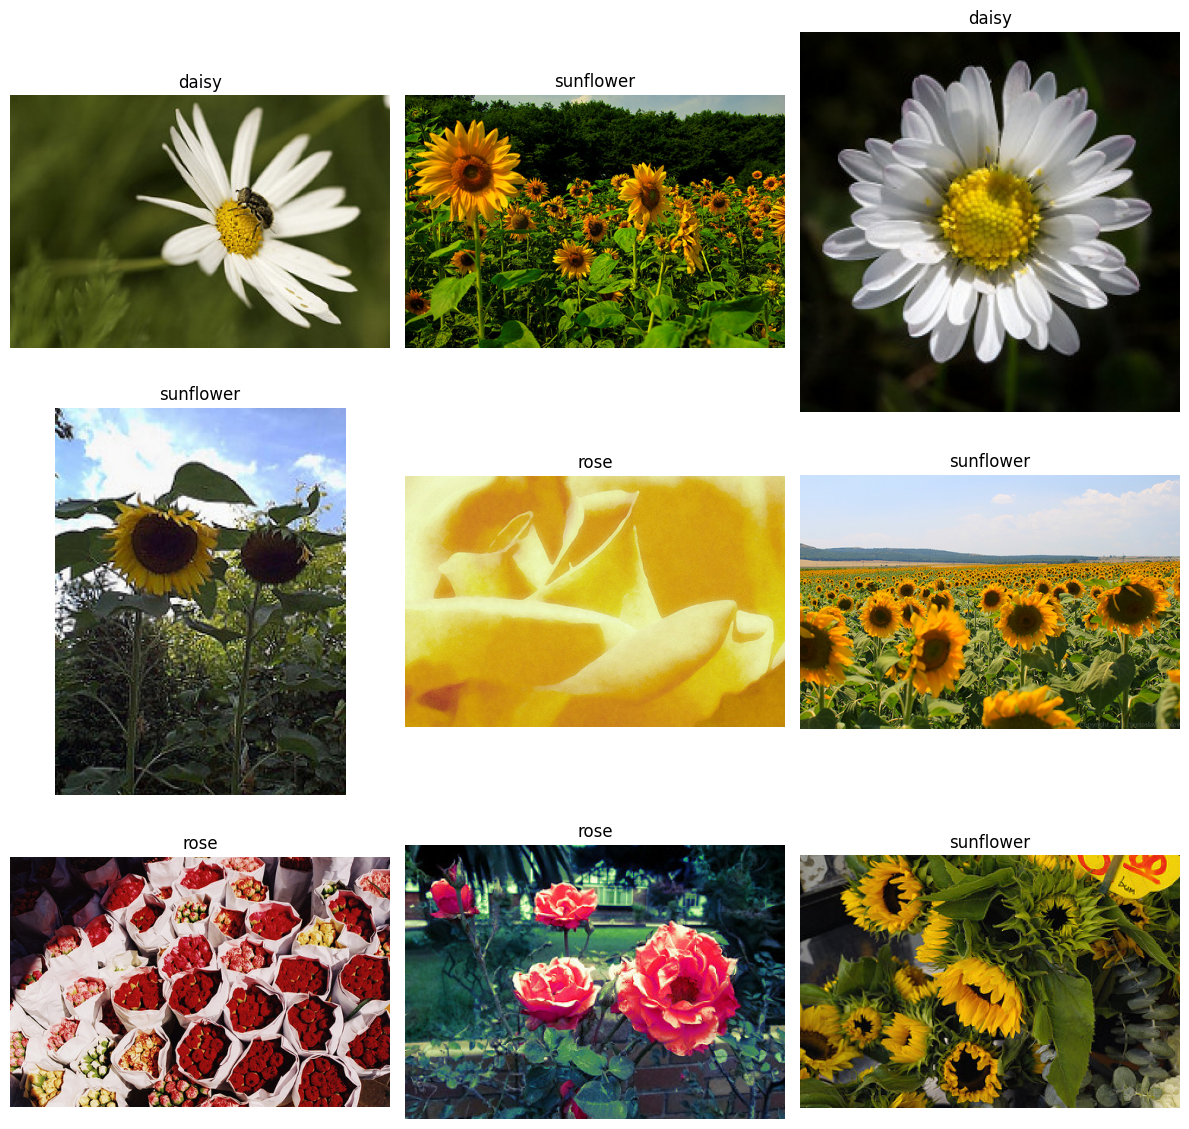

In [5]:
plt.figure(figsize=(12, 12))
for i in range(9):
    class_name = random.choice(classes)
    class_path = os.path.join(data_dir, class_name)
    file_name = random.choice(os.listdir(class_path))
    file_path = os.path.join(class_path, file_name)
    
    img = mpimg.imread(file_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


## 6. Eğitim ve Doğrulama Veri Akışlarının Oluşturulması

*‘flow_from_directory’* fonksiyonu ile, verilerin eğitim ve doğrulama kümelerine ayrılması ve generatorlerin hazırlanması sağlanıyor.


In [7]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


## 7. Basit CNN Modelinin Kurulması

Convolutional Neural Network mimarisi oluşturuluyor ve model derleniyor.


In [8]:
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


I0000 00:00:1758827530.113943      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## 8. Modelin Eğitilmesi

Model, eğitim verisi ile belirli epoch boyunca eğitilip, doğrulama verisi ile performansı izleniyor.


In [9]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20


I0000 00:00:1758827534.967714      75 service.cc:148] XLA service 0x7fad30004b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758827534.968439      75 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758827535.263963      75 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/109 ━━━━━━━━━━━━━━━━━━━━ 10:58 6s/step - accuracy: 0.1562 - loss: 1.6175

I0000 00:00:1758827538.295066      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


109/109 ━━━━━━━━━━━━━━━━━━━━ 47s 382ms/step - accuracy: 0.2851 - loss: 1.6072 - val_accuracy: 0.4651 - val_loss: 1.2308 - learning_rate: 0.0010
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 24s 220ms/step - accuracy: 0.4554 - loss: 1.2397 - val_accuracy: 0.5047 - val_loss: 1.2079 - learning_rate: 0.0010
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 24s 218ms/step - accuracy: 0.5189 - loss: 1.1951 - val_accuracy: 0.4965 - val_loss: 1.3064 - learning_rate: 0.0010
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 24s 219ms/step - accuracy: 0.5425 - loss: 1.1236 - val_accuracy: 0.5209 - val_loss: 1.2665 - learning_rate: 0.0010
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 24s 218ms/step - accuracy: 0.6046 - loss: 1.0003 - val_accuracy: 0.6512 - val_loss: 0.9233 - learning_rate: 2.0000e-04
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 24s 216ms/step - accuracy: 0.6333 - loss: 0.9671 - val_accuracy: 0.6581 - val_loss: 0.9173 - learning_rate: 2.0000e-04
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 23s 214ms/step - accuracy: 0.6393

## 9. Eğitim ve Doğrulama Sonuçlarının Görselleştirilmesi

Modelin epoch bazında eğitim ve doğrulama başarı/kayıp değerleri çizgi grafiği ile görselleştirilmesi sağlanıyor.


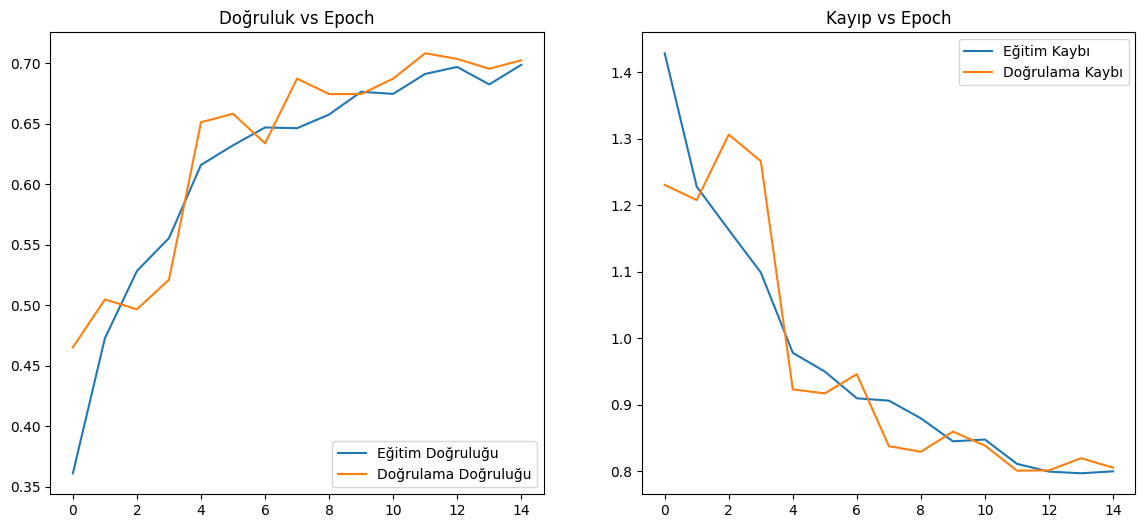

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
plt.legend(loc='lower right')
plt.title('Doğruluk vs Epoch')
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Kayıp vs Epoch')
plt.show()


## 10. Sınıflandırma Raporu ve Confusion Matrix

Sınıflar bazında model performansı raporlanıyor, hangi türlerin daha çok karıştığı böylelikle gözlemlenebilir.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
📋 Sınıflandırma Raporu:

              precision    recall  f1-score   support

       daisy       0.85      0.66      0.74       152
   dandelion       0.76      0.78      0.77       210
        rose       0.62      0.51      0.56       156
   sunflower       0.62      0.90      0.73       146
       tulip       0.72      0.69      0.70       196

    accuracy                           0.71       860
   macro avg       0.71      0.71      0.70       860
weighted avg       0.72      0.71      0.71       860



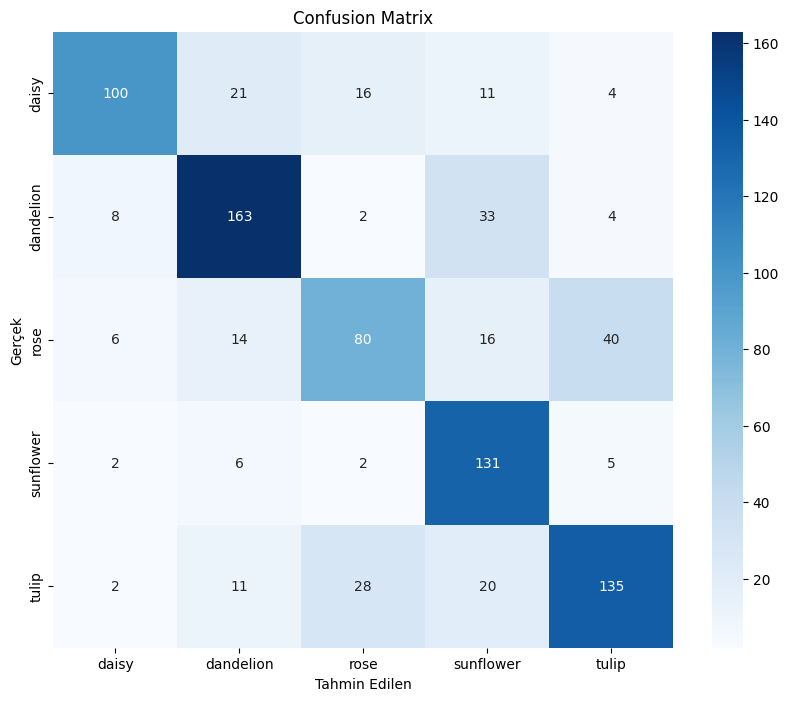

In [11]:
validation_generator.reset()
Y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())
print("📋 Sınıflandırma Raporu:\n")
print(classification_report(true_classes, y_pred, target_names=class_labels))
cm = confusion_matrix(true_classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()


## 11. Doğrulama Kümesindeki Sonuçların Değerlendirilmesi

Modelin doğrulama verisindeki genel doğruluk oranı ve kayıp değeri ekrana yazdırılıyor.


In [12]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {val_accuracy*100:.2f}%")


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.6833 - loss: 0.8975
Validation accuracy: 70.81%


## 12. Yanlış Sınıflandırılan Görsellerin Görselleştirilmesi

Modelin yanlış sınıflandırdığı ilk 9 görsel, gerçek ve tahmini label’ları ile birlikte görselleştiriliyor. Bu aşama ileride yapabileceğimiz iyileştirmeler için yön gösterici olabilir.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


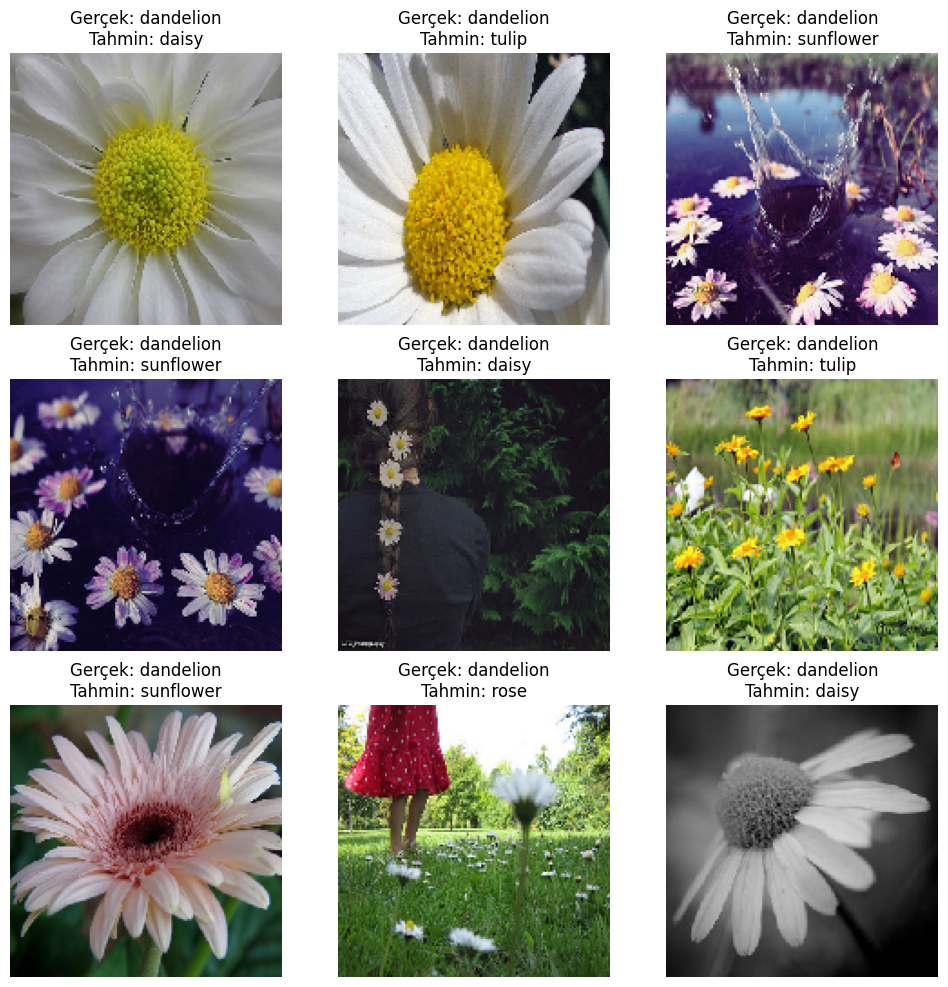

In [13]:
images, labels = next(validation_generator)
preds = model.predict(images)
preds_classes = np.argmax(preds, axis=1)
true_classes_batch = np.argmax(labels, axis=1)
wrong_idxs = np.where(preds_classes != true_classes_batch)[0]
plt.figure(figsize=(12,12))
for i, wrong in enumerate(wrong_idxs[:9]):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[wrong])
    ax.set_title(f"Gerçek: {classes[true_classes_batch[wrong]]}\nTahmin: {classes[preds_classes[wrong]]}")
    plt.axis('off')
plt.show()
